In [ ]:
!pip install pyspark

# KNN

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev
import numpy as np
import random
from pyspark.sql import functions as F
import os
from math import sqrt
from google.colab import drive

In [ ]:
spark = SparkSession.builder \
    .appName("KNN") \
    .master("local[*]").getOrCreate()

In [ ]:
drive.mount('/content/drive')
MAIN_PATH = "/content/drive/MyDrive/BigData"
data_path = os.path.join(MAIN_PATH, "processed_stroke_dataset.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = spark.read.option("header", True).option("inferSchema", True).csv(data_path)

In [ ]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: double (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: double (nullable = true)
 |-- heart_disease: double (nullable = true)
 |-- ever_married: double (nullable = true)
 |-- work_type: double (nullable = true)
 |-- Residence_type: double (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: double (nullable = true)
 |-- stroke: double (nullable = true)



In [ ]:
df.show(10)

+-----+------+-------------+------------+-------------+------------+---------+--------------+--------------------+-------------------+--------------+------+
|   id|gender|          age|hypertension|heart_disease|ever_married|work_type|Residence_type|   avg_glucose_level|                bmi|smoking_status|stroke|
+-----+------+-------------+------------+-------------+------------+---------+--------------+--------------------+-------------------+--------------+------+
| 9046|   1.0|0.81689453125|         0.0|          1.0|         1.0|      1.0|           1.0|  0.8012648878219923| 0.3012600229095075|           1.0|   1.0|
|51676|   0.0|0.74365234375|         0.0|          0.0|         1.0|      1.0|           0.0|  0.6790231742221402|0.21305841924398625|           0.0|   1.0|
|31112|   1.0| 0.9755859375|         0.0|          1.0|         1.0|      1.0|           0.0| 0.23451204874896134| 0.2542955326460481|           0.0|   1.0|
|60182|   0.0|0.59716796875|         0.0|          0.0|   

In [ ]:
df.head()

Row(id=9046, gender=1.0, age=0.81689453125, hypertension=0.0, heart_disease=1.0, ever_married=1.0, work_type=1.0, Residence_type=1.0, avg_glucose_level=0.8012648878219923, bmi=0.3012600229095075, smoking_status=1.0, stroke=1.0)

In [ ]:
df.columns

['id',
 'gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

In [ ]:
df.describe().toPandas().T

0                    1                    2    3      4
summary            count                 mean               stddev  min    max
id                  5110    36517.82935420744    21161.72162482715   67  72940
gender              5110  0.41389432485322897   0.4925782118215218  0.0    1.0
age                 5110   0.5266920713062623   0.2760332851942568  0.0    1.0
hypertension        5110   0.0974559686888454    0.296606674233791  0.0    1.0
heart_disease       5110  0.05401174168297456  0.22606298750336554  0.0    1.0
ever_married        5110   0.6561643835616439  0.47503352003736926  0.0    1.0
work_type           5110   0.7326810176125245   0.4426035248649552  0.0    1.0
Residence_type      5110   0.5080234833659492  0.49998454413026805  0.0    1.0
avg_glucose_level   5110  0.23556309252939828  0.20904607215668897  0.0    1.0
bmi                 5110   0.2129839969693106  0.08817889964650566  0.0    1.0
smoking_status      5110   0.3275929549902153  0.46938142920306986  0.0    1.0
stroke              5110   0.0487279843444227  0.21531985698023753  0.0    1.0

In [ ]:
# Xác định các cột đặc trưng (trừ các cột không phải là đặc trưng như 'id' và 'stroke')
feature_columns = [col for col in df.columns if col not in ['id', 'stroke']]

# Tính toán trung bình và độ lệch chuẩn của các đặc trưng
mean_stddev = df.select(
    *[F.mean(col).alias(f"{col}_mean") for col in feature_columns],
    *[F.stddev(col).alias(f"{col}_stddev") for col in feature_columns]
).collect()[0]

# Hàm chuẩn hóa Z-Score
def normalize_row(row):
    normalized_features = [
        (row[c] - mean_stddev[f"{c}_mean"]) / mean_stddev[f"{c}_stddev"]
        if mean_stddev[f"{c}_stddev"] != 0 else 0
        for c in feature_columns
    ]
    return [row['id']] + normalized_features + [row['stroke']]

# Chuẩn hóa dữ liệu
normalized_rdd = df.rdd.map(normalize_row)
normalized_df = spark.createDataFrame(normalized_rdd, schema=['id'] + feature_columns + ['stroke'])

# Xem xét lại dữ liệu đã chuẩn hóa
normalized_df.show(10)

+-----+------------------+------------------+--------------------+--------------------+-------------------+------------------+------------------+--------------------+--------------------+------------------+------+
|   id|            gender|               age|        hypertension|       heart_disease|       ever_married|         work_type|    Residence_type|   avg_glucose_level|                 bmi|    smoking_status|stroke|
+-----+------------------+------------------+--------------------+--------------------+-------------------+------------------+------------------+--------------------+--------------------+------------------+------+
| 9046|1.1898733258610665|1.0513313991807527|-0.32856970916314837|   4.184622475198165| 0.7238133772355849|0.6039693933053029| 0.983983449908142|  2.7061106169389126|  1.0011014686515773|1.4325386629620562|   1.0|
|51676|-0.840261129948633|0.7859931540178323|-0.32856970916314837|-0.23892341811226597| 0.7238133772355849|0.6039693933053029|-1.016078375481916

Các giá trị chuẩn hóa có thể âm: Vì chuẩn hóa Z-Score được tính bằng cách trừ đi giá trị trung bình và chia cho độ lệch chuẩn, các giá trị của các đặc trưng có thể là âm hoặc dương, tùy thuộc vào vị trí của giá trị so với trung bình. Điều này là hoàn toàn bình thường và cần thiết, vì nó giúp đưa các đặc trưng về cùng một phạm vi để thuật toán có thể so sánh chúng một cách công bằng.

In [ ]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra (80% huấn luyện, 20% kiểm tra)
train_df, test_df = normalized_df.randomSplit([0.8, 0.2], seed=0)

# Oversampling lớp thiểu số
minority_class = train_df.filter(col("stroke") == 1.0)
majority_class = train_df.filter(col("stroke") == 0.0)

# Sao chép các mẫu từ lớp thiểu số
oversampling_fraction = 3.0
oversampled_minority = minority_class.sample(withReplacement=True, fraction=oversampling_fraction)
balanced_train_df = majority_class.union(oversampled_minority)

# Kiểm tra lại phân phối
balanced_train_df.groupBy("stroke").count().show()

train_df.groupBy('stroke').count().show()
test_df.groupBy('stroke').count().show()

# Đếm số lượng mẫu trong tập huấn luyện và kiểm tra
train_count = train_df.count()
test_count = test_df.count()

# In kết quả số lượng mẫu
print(f"Số lượng dữ liệu huấn luyện: {train_count}")
print(f"Số lượng dữ liệu kiểm tra: {test_count}")

+------+-----+
|stroke|count|
+------+-----+
|   0.0| 3863|
|   1.0|  601|
+------+-----+

+------+-----+
|stroke|count|
+------+-----+
|   0.0| 3863|
|   1.0|  194|
+------+-----+

+------+-----+
|stroke|count|
+------+-----+
|   0.0|  998|
|   1.0|   55|
+------+-----+

Số lượng dữ liệu huấn luyện: 4057
Số lượng dữ liệu kiểm tra: 1053


In [ ]:
# Hàm tính khoảng cách Euclidean giữa 2 điểm
def euclidean_distance(point1, point2):
    return sqrt(sum((float(x) - float(y)) ** 2 for x, y in zip(point1[1:-1], point2[1:-1])))


In [ ]:
# Hàm KNN
def knn(train_data_list, test_point, k, alpha=1.0):
    test_point_list = list(test_point)  # Chuyển Row thành danh sách
    distances = [(euclidean_distance(test_point_list, list(train_point.values())), train_point['stroke']) for train_point in train_data_list]
    nearest_neighbors = sorted(distances, key=lambda x: x[0])[:k]  # Lấy k điểm gần nhất

    # Trọng số giảm theo hàm mũ và alpha để điều chỉnh tác động của khoảng cách
    label_weights = {}
    for dist, label in nearest_neighbors:
        weight = np.exp(-alpha * dist)  # Áp dụng alpha để điều chỉnh trọng số
        label_weights[label] = label_weights.get(label, 0) + weight

    prediction = max(label_weights, key=label_weights.get)
    return prediction

In [ ]:
def evaluate_predictions(predictions_list):
    true_positives = sum(1 for actual, predicted in predictions_list if actual == 1.0 and predicted == 1.0)
    true_negatives = sum(1 for actual, predicted in predictions_list if actual == 0.0 and predicted == 0.0)
    false_positives = sum(1 for actual, predicted in predictions_list if actual == 0.0 and predicted == 1.0)
    false_negatives = sum(1 for actual, predicted in predictions_list if actual == 1.0 and predicted == 0.0)

    accuracy = (true_positives + true_negatives) / len(predictions_list)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1_score

In [ ]:
best_k = None
best_f1_score = 0
best_accuracy = 0
train_data_list = balanced_train_df.rdd.map(lambda row: row.asDict()).cache().collect()
train_data_broadcast = spark.sparkContext.broadcast(train_data_list)
accuracies = []
f1_scores = []
k_values = range(1, 7)

for k in range(1, 21):
    predictions = test_df.rdd.map(lambda test_point: (test_point[-1], knn(train_data_list, test_point, k)))
    predictions_list = predictions.collect()
    accuracy, precision, recall, f1_score = evaluate_predictions(predictions_list)

    accuracies.append(accuracy)
    f1_scores.append(f1_score)

    if f1_score > best_f1_score or (f1_score == best_f1_score and accuracy > best_accuracy):
      best_accuracy = accuracy
      best_f1_score = f1_score
      best_k = k

    print(f"K = {k}, Accuracy = {accuracy:.2f}, Precision = {precision:.2f}, Recall = {recall:.2f}, F1 Score = {f1_score:.2f}")

K = 1, Accuracy = 0.92, Precision = 0.17, Recall = 0.11, F1 Score = 0.13
K = 2, Accuracy = 0.92, Precision = 0.17, Recall = 0.11, F1 Score = 0.13
K = 3, Accuracy = 0.90, Precision = 0.13, Recall = 0.16, F1 Score = 0.15
K = 4, Accuracy = 0.90, Precision = 0.12, Recall = 0.13, F1 Score = 0.12
K = 5, Accuracy = 0.89, Precision = 0.09, Recall = 0.13, F1 Score = 0.11
K = 6, Accuracy = 0.89, Precision = 0.10, Recall = 0.13, F1 Score = 0.11
K = 7, Accuracy = 0.89, Precision = 0.15, Recall = 0.22, F1 Score = 0.18
K = 8, Accuracy = 0.91, Precision = 0.17, Recall = 0.20, F1 Score = 0.18
K = 9, Accuracy = 0.91, Precision = 0.15, Recall = 0.16, F1 Score = 0.16
K = 10, Accuracy = 0.91, Precision = 0.15, Recall = 0.15, F1 Score = 0.15
K = 11, Accuracy = 0.92, Precision = 0.17, Recall = 0.15, F1 Score = 0.16
K = 12, Accuracy = 0.92, Precision = 0.17, Recall = 0.15, F1 Score = 0.16
K = 13, Accuracy = 0.92, Precision = 0.16, Recall = 0.13, F1 Score = 0.14
K = 14, Accuracy = 0.92, Precision = 0.18, Reca

In [ ]:
# Tính toán true positives, true negatives, false positives, false negatives
true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0

# Tính toán các giá trị trên driver
for prediction in predictions_list:
    actual = prediction[0]  # Thực tế (label)
    predicted = prediction[1]  # Dự đoán

    if actual == 1.0 and predicted == 1.0:
        true_positives += 1
    elif actual == 0.0 and predicted == 0.0:
        true_negatives += 1
    elif actual == 0.0 and predicted == 1.0:
        false_positives += 1
    elif actual == 1.0 and predicted == 0.0:
        false_negatives += 1
print(f"True Positives: {true_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")

# Tính các chỉ số đánh giá
accuracy = (true_positives + true_negatives) / len(predictions_list)
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# In các chỉ số đánh giá
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

True Positives: 6
True Negatives: 976
False Positives: 22
False Negatives: 49
Accuracy: 0.93
Precision: 0.21
Recall: 0.11
F1 Score: 0.14


Độ chính xác cao nhưng điểm F1 thấp trong trường hợp này là do sự mất cân bằng của bộ dữ liệu. Mô hình có thể thiên về dự đoán cho lớp đa số (không đột quỵ) và dẫn đến hiệu suất kém đối với lớp thiểu số (đột quỵ).

Giá trị K tốt nhất: 8
Độ chính xác tốt nhất: 0.91
F1-Score: 0.18


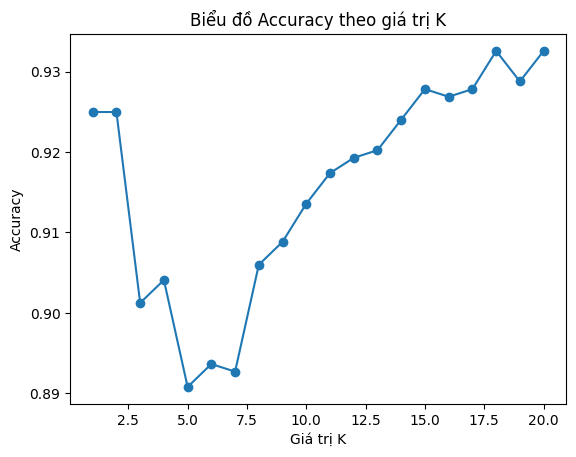

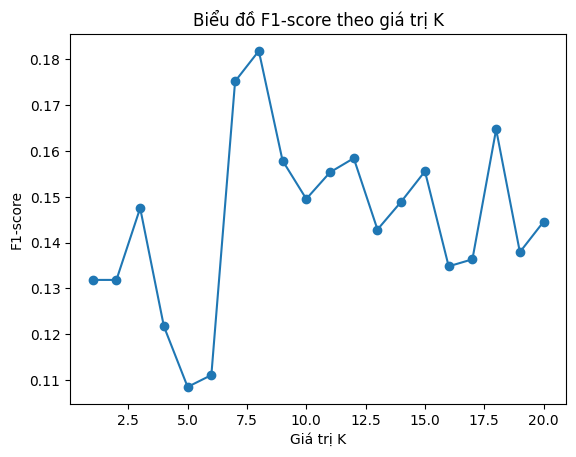

In [ ]:
import matplotlib.pyplot as plt

print(f"Giá trị K tốt nhất: {best_k}")
print(f"Độ chính xác tốt nhất: {best_accuracy:.2f}")
print(f"F1-Score: {best_f1_score:.2f}")

# Vẽ biểu đồ Accuracy
plt.plot(list(range(1, len(accuracies) + 1)), accuracies, marker='o')
plt.xlabel('Giá trị K')
plt.ylabel('Accuracy')
plt.title('Biểu đồ Accuracy theo giá trị K')
plt.show()

# Vẽ biểu đồ F1-score
plt.plot(list(range(1, len(f1_scores) + 1)), f1_scores, marker='o')
plt.xlabel('Giá trị K')
plt.ylabel('F1-score')
plt.title('Biểu đồ F1-score theo giá trị K')
plt.show()

In [ ]:
# Dự đoán nhãn cho toàn bộ tập kiểm tra
predictions = test_df.rdd.map(lambda test_point: (test_point[-1], knn(train_data_list, test_point, best_k)))

# Lưu trữ kết quả dự đoán vào một danh sách
predictions_list = predictions.collect()

In [ ]:
import numpy as np

# Trích xuất các nhãn dự đoán từ predictions_list
predicted_labels = [prediction[1] for prediction in predictions_list]

# Chuyển đổi danh sách thành mảng numpy
predicted_labels_array = np.array(predicted_labels, dtype=np.int64)

print("Độ dài predict:",len(predicted_labels_array))

# Kiểm tra nhãn dự đoán
print(predicted_labels_array[:500])

Độ dài predict: 1053
[0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0

In [ ]:
pandas_df = test_df.toPandas()
pandas_df['predicted'] = predicted_labels_array
pandas_df.to_excel('predicted_results.xlsx', index=False)

# Conclusion

Mặc dù thuật toán KNN đã được áp dụng với một số cải tiến (như oversampling và sử dụng trọng số theo khoảng cách), kết quả cho thấy mô hình vẫn chưa đạt được hiệu suất như mong muốn, đặc biệt ở các chỉ số liên quan đến lớp thiểu số. Điều này chỉ ra rằng KNN có một số hạn chế trong việc xử lý bộ dữ liệu này.

Kết quả với mô hình KNN trên bộ dữ liệu này không thực sự tốt.

Mặc dù đã tìm được các tham số phù hợp nhất, nhóm vẫn không đạt được sự cải thiện đáng kể như mong đợi trong kết quả.

Bộ dữ liệu hiện tại có sự mất cân bằng rõ rệt giữa các lớp (đa số là 0, thiểu số là 1). Điều này khiến KNN bị ảnh hưởng nghiêm trọng bởi sự mất cân bằng, dẫn đến việc mô hình thiên về dự đoán cho lớp đa số.